In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.multiclass import unique_labels

The provided Mobile Crowd Sensing (MCS) dataset.

In [ ]:
data = pd.read_csv('MCSDatasetNEXTCONLab.csv')
print(data.head())

The dataset
consists of some features such as Latitude, Longitude, Day, Hour, Minute, Duration,
RemainingTime, Resources, Coverage, OnPeakHours, GridNumber, Ligitimacy. Legitimacy will be used as an output and according to day feature you need to generate
training and test datasets. The values 0, 1 and 2 in column day should be used for
training dataset and only the value 3 in column day should be used for test dataset.


#**Problem 1**

The values 0, 1 and 2 in column day should be used for training dataset and only the value 3 in column day should be used for test dataset.

ID indicates the index and it cannot be used as the feature. Feature day is different
for training and test datasets so it cannot be used as feature in datasets.

Please use
color code and different line style in your figures.

### a) Create training and test datasets for remaining parts according to day feature in the dataset (column: ”day”)

In [ ]:
train_data = data.loc[data.Day.isin([0, 1, 2])]
test_data = data[data.Day == 3]
train_data = train_data.drop(['ID','Day'],axis = 1)
test_data = test_data.drop(['ID','Day'],axis = 1)
x_train = train_data.drop('Ligitimacy',axis = 1)
y_train = train_data.Ligitimacy
x_test = test_data.drop('Ligitimacy',axis = 1)
y_test = test_data.Ligitimacy

##Use scikit-learn to implement Naive Bayes Classifier ( NB ) and K-Nearest Neighbor (KNN ) classifiers

###b) Provide confusion matrixes and F1 scores of NB and KNN classifier as baseline performances.

In [ ]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
f1_nb = f1_score(y_test, y_pred_nb)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("F1 score for Gaussian Naive Bayes : ", f1_nb)

F1 score for Gaussian Naive Bayes :  0.9322916666666667


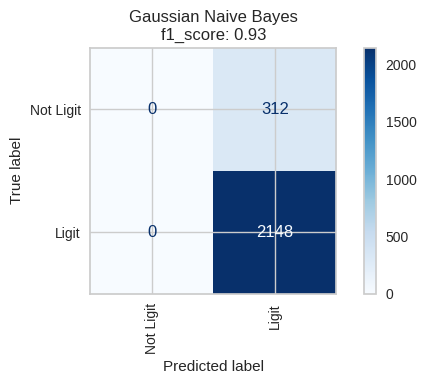

In [ ]:
#drawing the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(6, 4))
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Not Ligit", "Ligit"])
disp_mnb.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
ax.set_title("Gaussian Naive Bayes\nf1_score: {:.2f}".format(f1_nb))
plt.tight_layout()
plt.show()

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(x_test)

# Calculate the F1 score
f1_knn = f1_score(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("F1 score for KNN: ", f1_knn)

F1 score for KNN:  0.9227557411273487


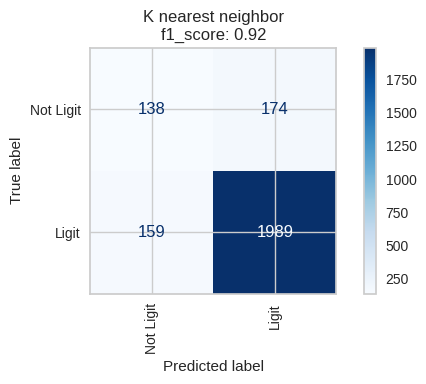

In [ ]:
#drawing the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(6, 4))
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Not Ligit", "Ligit"])
disp_mnb.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
ax.set_title("K nearest neighbor\nf1_score: {:.2f}".format(f1_knn))
plt.tight_layout()
plt.show()

###c) Provide 2D TSNE plots, one for the training set and one for the test set

In [ ]:
def plot_tsne(X, y, target_names):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    target_ids = range(len(target_names))

    plt.figure(figsize=(8, 6))

    # Define markers and colors for each class
    markers = ['o', 's', 'D', 'v', '^', 'p', 'h', '*', '+', 'x']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

    for i, c, label, marker in zip(target_ids, colors, target_names, markers):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label, marker=marker, alpha=0.7)

    plt.legend()
    plt.title("t-SNE Plot")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
target_names = np.flip(data['Ligitimacy'].unique())

TSNE for train data

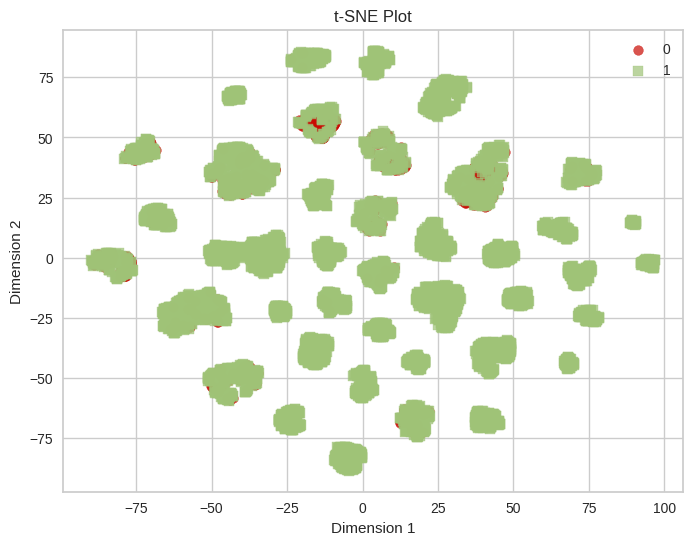

In [ ]:
plot_tsne(x_train, y_train, target_names)

TSNE for testdata

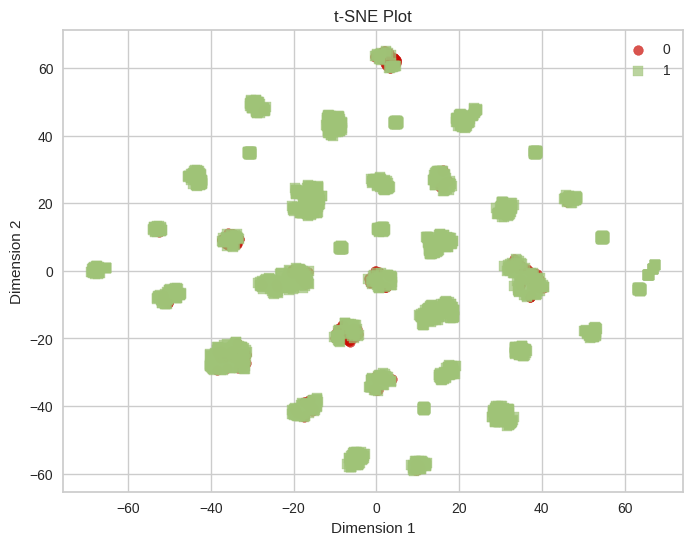

In [ ]:
plot_tsne(x_test, y_test, target_names)

#**Problem 2**

Apply the following Dimensionality Reduction (DR) methods:PCA(n components=n,
random state=0) and Auto Encoder (AE). AE structure should be from higher to
lower number of neurons, from outer to center.

##a) find the best reduced dimensions of PCA and AE based on f1 score of test dataset using both classifiers (NB and KNN)

Plot the number of components
(dimension) vs f1 score together with baseline performances for each classifier.

The Graph should be plotted based on the f1 score of test dataset. The total
number of figure will be 4 in this part.

###**PCA**

In [ ]:
n_components_range = [2, 4, 6, 8, 10]  # List of different PCA n components

f1_scores_nb_pca = []
f1_scores_knn_pca = []
best_f1_nb = 0
best_f1_knn = 0
best_n_components_nb = 0
best_n_components_knn = 0
for n_components in n_components_range:
    # Apply PCA to reduce the dimensionality
    pca = PCA(n_components=n_components,random_state = 0)
    pca.fit(x_train)
    X_train_pca = pca.transform(x_train)
    X_test_pca = pca.transform(x_test)

    nb.fit(X_train_pca, y_train)
    y_pred_nb = nb.predict(X_test_pca)
    f1_nb = f1_score(y_test, y_pred_nb)
    f1_scores_nb_pca.append(f1_nb)
    if f1_nb > best_f1_nb:
      best_f1_nb = f1_nb
      best_n_components_nb = n_components


    knn_model.fit(X_train_pca, y_train)
    y_pred_knn = knn_model.predict(X_test_pca)
    f1_knn = f1_score(y_test, y_pred_knn)
    f1_scores_knn_pca.append(f1_knn)

    if f1_knn > best_f1_knn:
      best_f1_knn = f1_knn
      best_n_components_knn = n_components


print("Best n_components for Naive Bayes:", best_n_components_nb)
print("Best F1 score for Naive Bayes:", best_f1_nb)

print("Best n_components for KNN:", best_n_components_knn)
print("Best F1 score for KNN:", best_f1_knn)

Best n_components for Naive Bayes: 2
Best F1 score for Naive Bayes: 0.9322916666666667
Best n_components for KNN: 2
Best F1 score for KNN: 0.9481165600568585


###**Gauss NB**

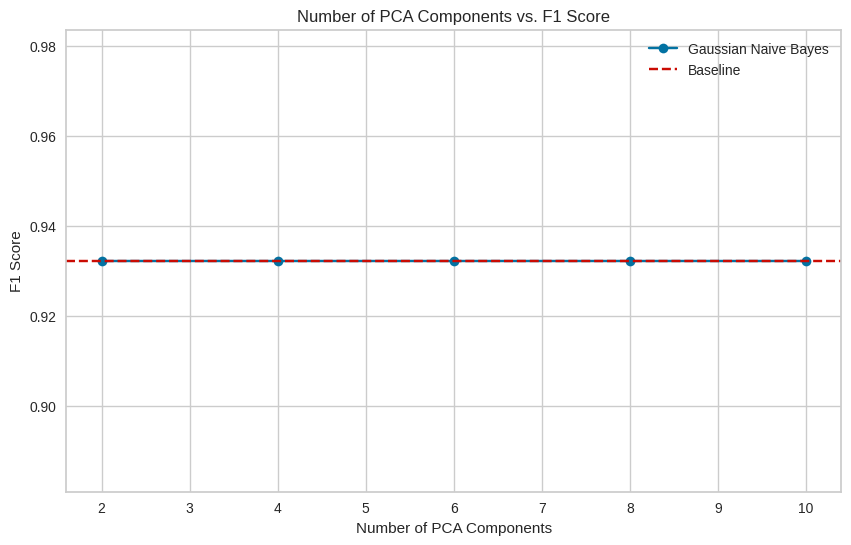

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, f1_scores_nb_pca, marker='o', label="Gaussian Naive Bayes")
plt.axhline(y=f1_nb, color='r', linestyle='--', label="Baseline")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1 Score")
plt.title("Number of PCA Components vs. F1 Score")
plt.legend()
plt.show()

###**KNN**

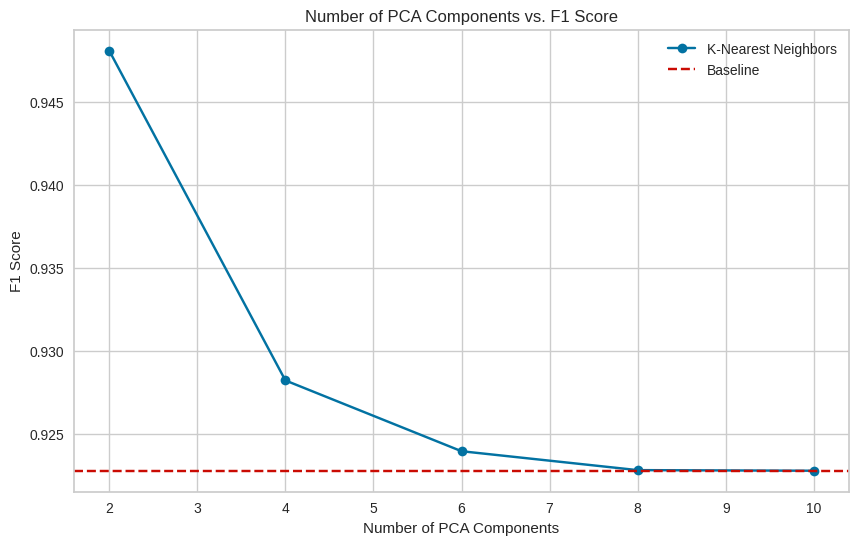

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, f1_scores_knn_pca, marker='o', label="K-Nearest Neighbors")
plt.axhline(y=f1_knn, color='r', linestyle='--', label="Baseline")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1 Score")
plt.title("Number of PCA Components vs. F1 Score")
plt.legend()
plt.show()

##**Auto Encoder**

In [ ]:
# Scale the input data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)


In [ ]:
dimensions = [2, 4, 6, 8, 10]  # Dimensionality values to test


In [ ]:
best_f1_nb = 0
best_f1_knn = 0
best_n_features_nb = 0
best_n_features_knn = 0
f1_scores_nb_ae = []
f1_scores_knn_ae = []

for i, dim in enumerate(dimensions):
    # Train the autoencoder
    autoencoder = MLPRegressor(hidden_layer_sizes=[24, 12, dim], activation='relu', solver='adam', max_iter=1000)
    autoencoder.fit(X_train, X_train)

    # Reduce dimensionality with the trained autoencoder
    reduced_X_train = autoencoder.predict(X_train)
    reduced_X_test = autoencoder.predict(X_test)

    nb.fit(reduced_X_train, y_train)
    y_pred_nb = nb.predict(reduced_X_test)
    f1_nb = f1_score(y_test, y_pred_nb)
    f1_scores_nb_ae.append(f1_nb)

    if f1_nb > best_f1_nb:
        best_f1_nb = f1_nb
        best_n_features_nb = dim

    knn_model.fit(reduced_X_train, y_train)
    y_pred_knn = knn_model.predict(reduced_X_test)
    f1_knn = f1_score(y_test, y_pred_knn)
    f1_scores_knn_ae.append(f1_knn)

    if f1_knn > best_f1_knn:
        best_f1_knn = f1_knn
        best_n_features_knn = dim

print("Best F1 score for Naive Bayes:", best_f1_nb)
print("Number of features for best F1 score (Naive Bayes):", best_n_features_nb)
print("Best F1 score for KNN:", best_f1_knn)
print("Number of features for best F1 score (KNN):", best_n_features_knn)


Best F1 score for Naive Bayes: 0.8752455795677799
Number of features for best F1 score (Naive Bayes): 4
Best F1 score for KNN: 0.9322916666666667
Number of features for best F1 score (KNN): 2


###**GNB**

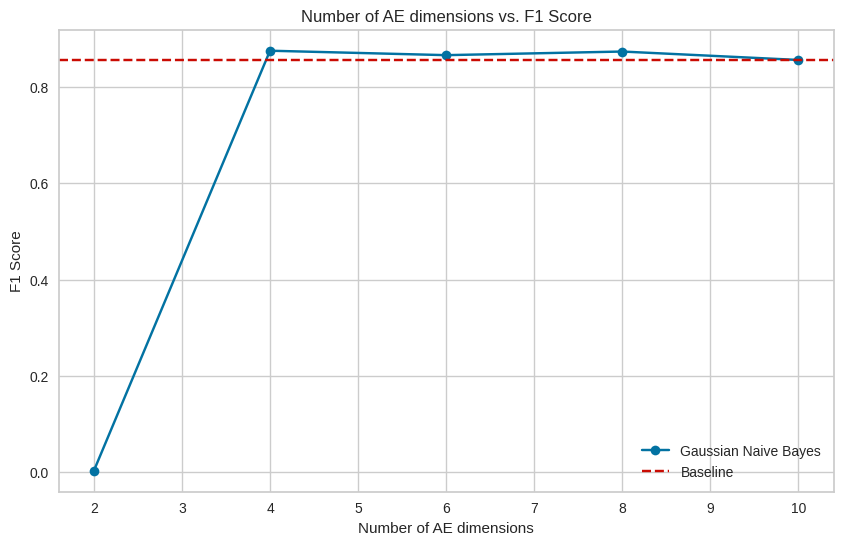

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, f1_scores_nb_ae, marker='o', label="Gaussian Naive Bayes")
plt.axhline(y=f1_nb, color='r', linestyle='--', label="Baseline")
plt.xlabel("Number of AE dimensions")
plt.ylabel("F1 Score")
plt.title("Number of AE dimensions vs. F1 Score")
plt.legend()
plt.show()


###**KNN**

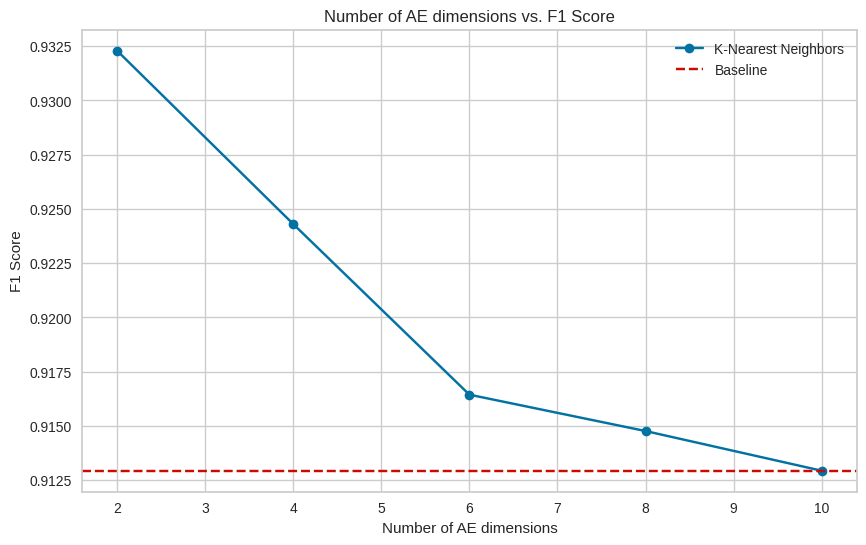

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dimensions, f1_scores_knn_ae, marker='o', label="K-Nearest Neighbors")
plt.axhline(y=f1_knn, color='r', linestyle='--', label="Baseline")
plt.xlabel("Number of AE dimensions")
plt.ylabel("F1 Score")
plt.title("Number of AE dimensions vs. F1 Score")
plt.legend()
plt.show()

##b) Provide 2D TSNE plots for the best performance in previous part (The best dimensionality reduction performance using one of the NB and KNN classifiers)


In [ ]:
pca = PCA(n_components=2 , random_state=0)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

One for the training set

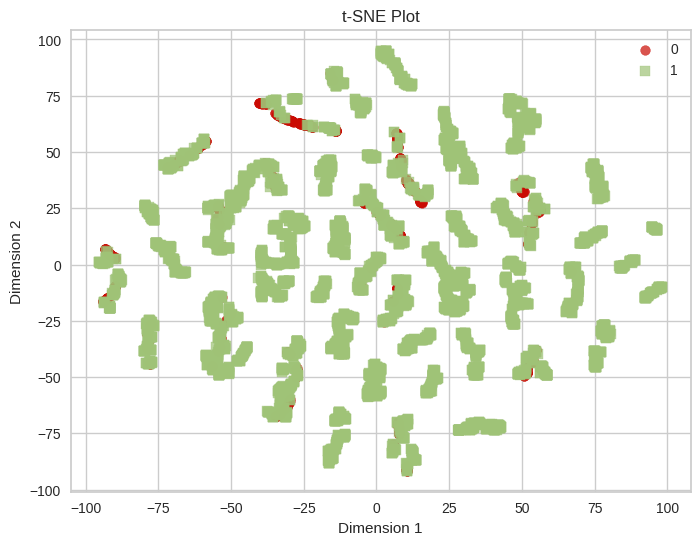

In [ ]:
plot_tsne(x_train_pca,y_train,target_names)

One for the test set.

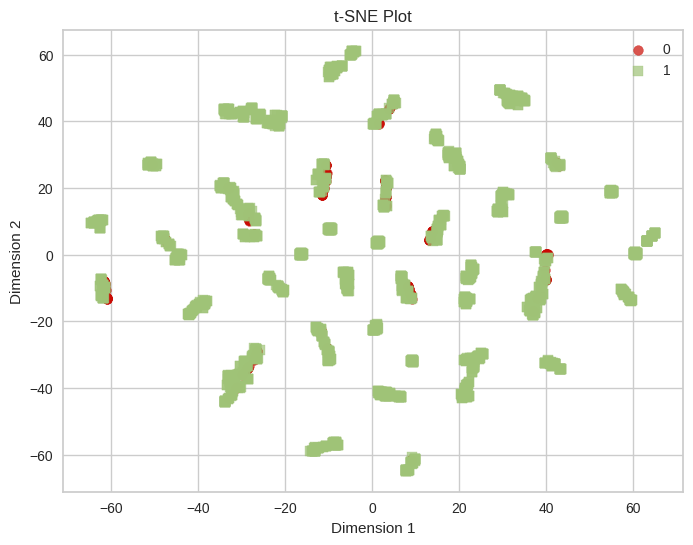

In [ ]:
plot_tsne(x_test_pca,y_test,target_names)

#**Problem 3**

Use the following Feature Selection methods (one for each method). Find the best
number of features based on both, the NB and KNN classifiers f1 scores

##a) Use the following Feature Selection methods (one for each method). Find the best number of features based on both, the NB and KNN classifiers f1 scores

###Filter Method

In [ ]:
filter_method = SelectKBest(score_func=mutual_info_classif)

n_features_range = [2,3,4,5,6,7,8,9,10,11]  # List of different numbers of features

f1_scores_nb_filter = []
f1_scores_knn_filter = []

for n_features in n_features_range:
    # Apply the Information Gain filter method to select the top k features
    filter_method.fit(x_train, y_train)
    X_train_filtered = filter_method.transform(x_train)[:, :n_features]
    X_test_filtered = filter_method.transform(x_test)[:, :n_features]

    nb.fit(X_train_filtered, y_train)
    y_pred_nb = nb.predict(X_test_filtered)
    f1_nb = f1_score(y_test, y_pred_nb)
    f1_scores_nb_filter.append(f1_nb)



    knn_model.fit(X_train_filtered, y_train)
    y_pred_knn = knn_model.predict(X_test_filtered)
    f1_knn = f1_score(y_test, y_pred_knn)
    f1_scores_knn_filter.append(f1_knn)

####GNB

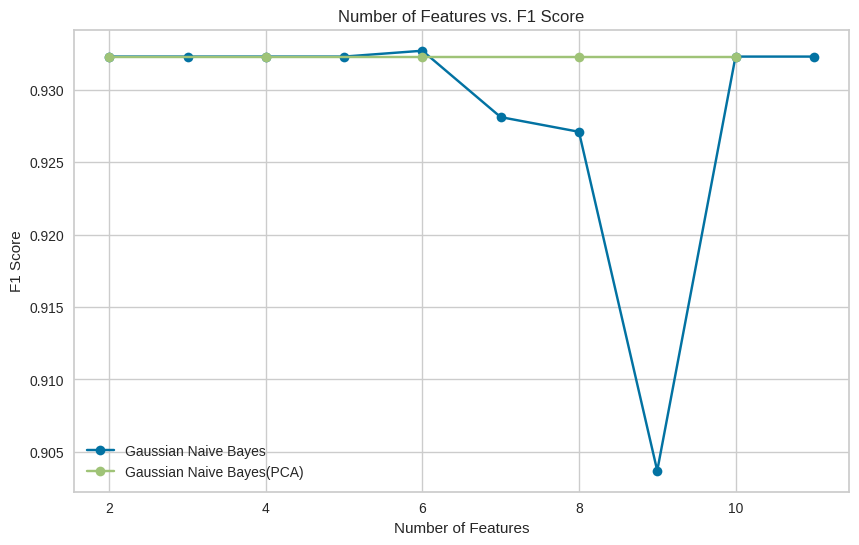

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, f1_scores_nb_filter, marker='o', label="Gaussian Naive Bayes")
plt.plot(n_components_range, f1_scores_nb_pca, marker='o', label="Gaussian Naive Bayes(PCA)")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("Number of Features vs. F1 Score")
plt.legend()
plt.show()

####KNN

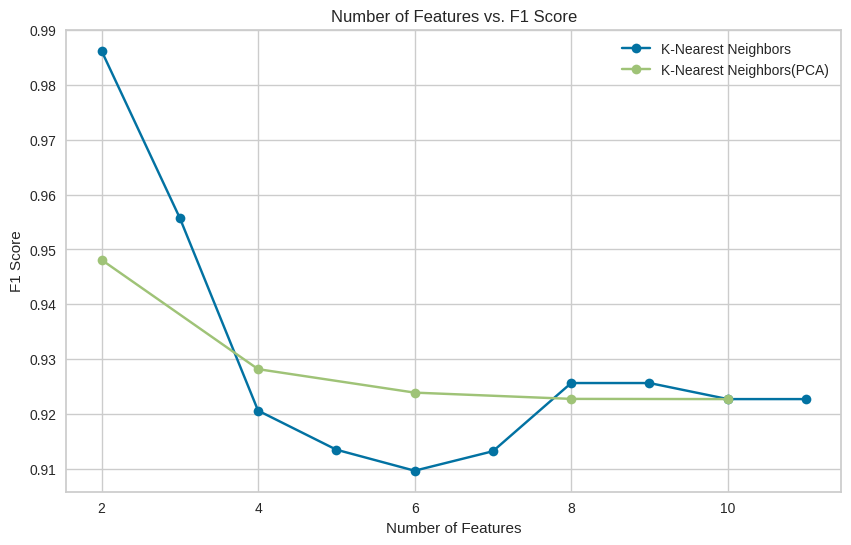

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, f1_scores_knn_filter, marker='o', label="K-Nearest Neighbors")
plt.plot(n_components_range, f1_scores_knn_pca, marker='o', label="K-Nearest Neighbors(PCA)")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("Number of Features vs. F1 Score")
plt.legend()
plt.show()

##b) Wrapper Methods (Forward or Backward Feature Elimination, Recursive Feature Elimination etc.). Plot the number of features versus accuracy graph with the baseline performance.

###Wrapper Method

In [ ]:
# Specify the range of different numbers of features
n_features_range = range(1, len(x_train.columns) )

# Initialize lists to store the number of features and corresponding accuracies
n_features_list = []
accuracy_knn_list = []
accuracy_nb_list = []

# Perform Sequential Feature Selection for KNN and Gaussian Naive Bayes
for n_features in n_features_range:
    # Perform SFS for KNN
    sfs_knn = SequentialFeatureSelector(knn_model, n_features_to_select=n_features, direction='forward')
    X_train_selected_knn = sfs_knn.fit_transform(X_train, y_train)
    X_test_selected_knn = sfs_knn.transform(X_test)
    knn_model.fit(X_train_selected_knn, y_train)
    accuracy_knn = knn_model.score(X_test_selected_knn, y_test)
    accuracy_knn_list.append(accuracy_knn)

    # Perform SFS for Gaussian Naive Bayes
    sfs_nb = SequentialFeatureSelector(nb, n_features_to_select=n_features, direction='forward')
    X_train_selected_nb = sfs_nb.fit_transform(X_train, y_train)
    X_test_selected_nb = sfs_nb.transform(X_test)
    nb.fit(X_train_selected_nb, y_train)
    accuracy_nb = nb.score(X_test_selected_nb, y_test)
    accuracy_nb_list.append(accuracy_nb)

    n_features_list.append(n_features)

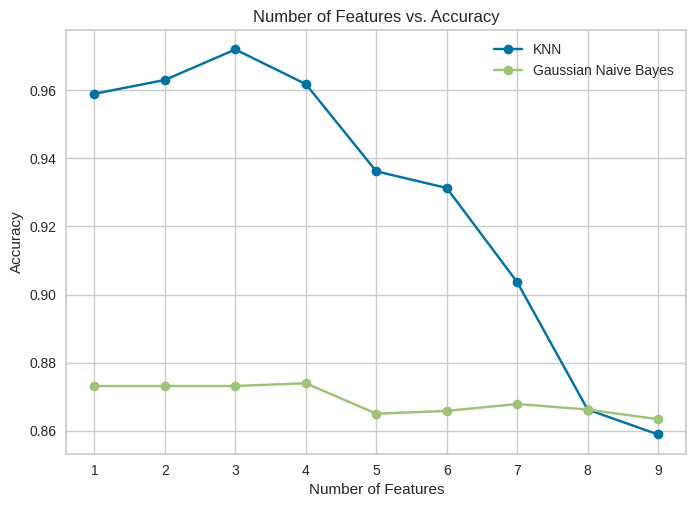

In [ ]:
# Plot the number of features versus accuracy graph
plt.plot(n_features_list, accuracy_knn_list, marker='o', label='KNN')
plt.plot(n_features_list, accuracy_nb_list, marker='o', label='Gaussian Naive Bayes')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of Features vs. Accuracy')
plt.legend()
plt.show()

###**GNB**

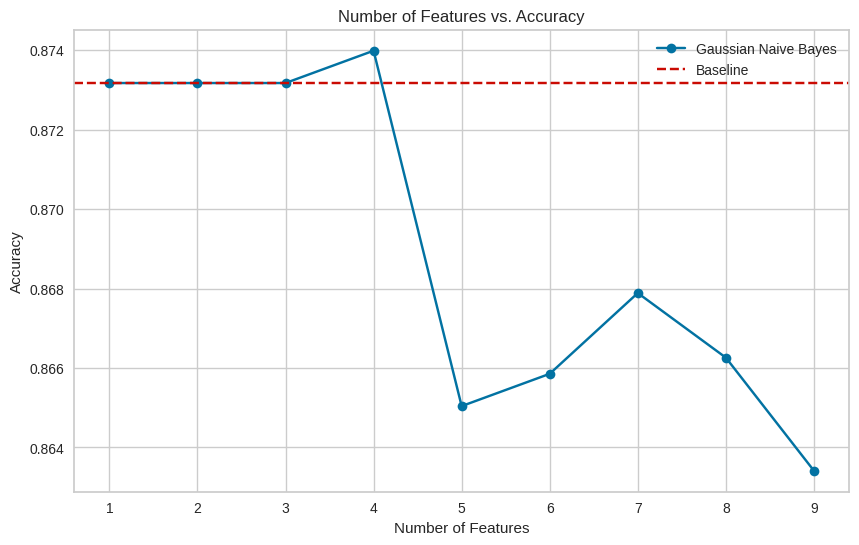

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_nb_list, marker='o', label='Gaussian Naive Bayes')
plt.axhline(y=nb_accuracy, color='r', linestyle='--', label="Baseline")
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of Features vs. Accuracy')
plt.legend()
plt.show()

###**KNN**

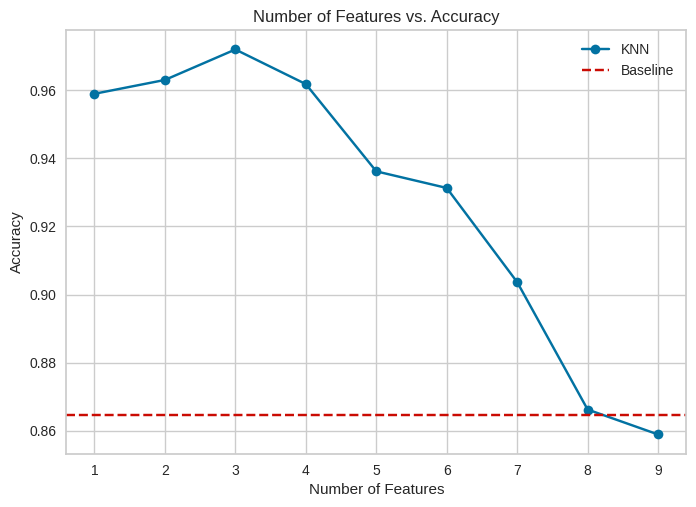

In [ ]:
# Plot the number of features versus accuracy graph
plt.plot(n_features_list, accuracy_knn_list, marker='o', label='KNN')
plt.axhline(y=knn_accuracy, color='r', linestyle='--', label="Baseline")
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of Features vs. Accuracy')
plt.legend()
plt.show()

##c) Provide 2D TSNE plots, using only the best method (either the filter or wrapper).

###Filter Method
As it's the best method

In [ ]:
filter_method.fit(x_train, y_train)
X_train_filtered = filter_method.transform(x_train)[:, :2]
X_test_filtered = filter_method.transform(x_test)[:, :2]

One for the train set.

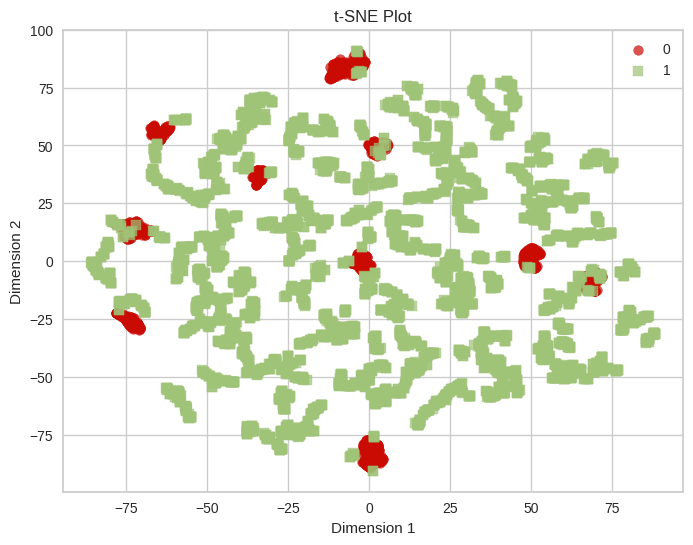

In [ ]:
plot_tsne(X_train_filtered,y_train,target_names)

One for the test set.

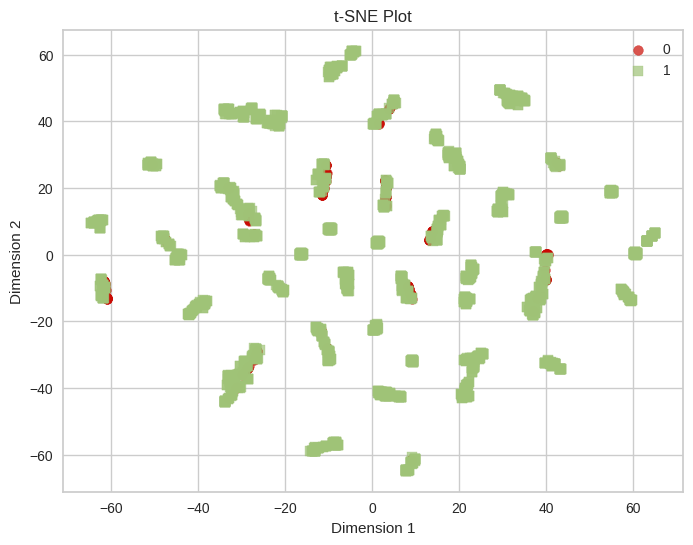

In [ ]:
plot_tsne(x_test_pca,y_test,target_names)

#**Problem 4**

Latitude and longitude features should be considered for clustering based methods.
Choose the best number of cluster among 8, 12, 16, 20 and 32 clusters. Legitimate
only clusters should be found and the maximum number of legitimate only members
in legitimate only clusters should be reported.

##a) Apply K-means algorithm to plot the number of clusters (8,12,16,20 and 32) vs the total number of legitimate only members inside the legitimate only clusters.

###Data

In [ ]:
df=pd.read_csv('/content/MCSDatasetNEXTCONLab.csv')
# Assuming your original dataset is stored in a DataFrame called 'df'

# Selecting the desired columns
selected_columns = ['Latitude', 'Longitude', 'Ligitimacy']
new_df = df[selected_columns]

# Splitting the dataset into train and test based on the 'Day' value
train_df = new_df[df['Day'].isin([1, 2])]
test_df = new_df[df['Day'] == 3]

# Separating the features (Latitude, Longitude) and target (Ligitimacy) for train and test datasets
X_train = train_df[['Latitude', 'Longitude']]
y_train = train_df['Ligitimacy']
X_test = test_df[['Latitude', 'Longitude']]
y_test = test_df['Ligitimacy']
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_train.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


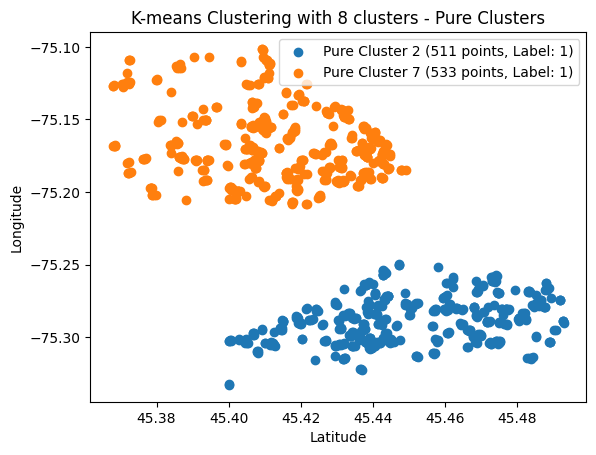

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


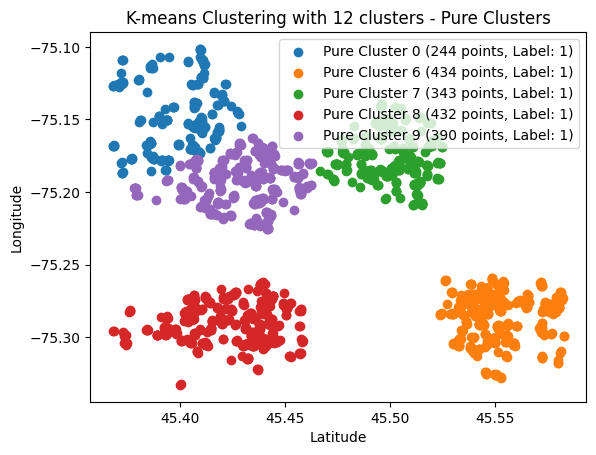

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


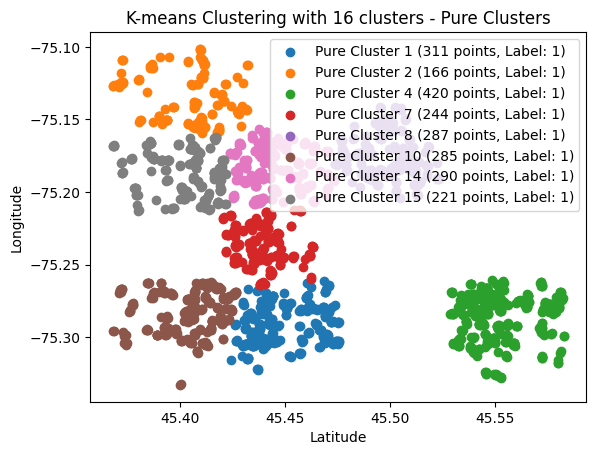

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


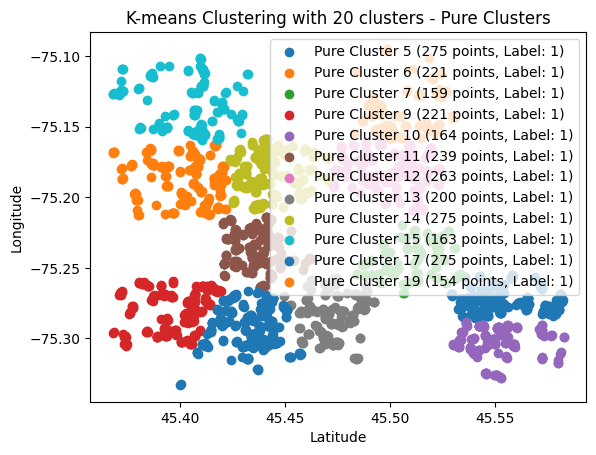

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


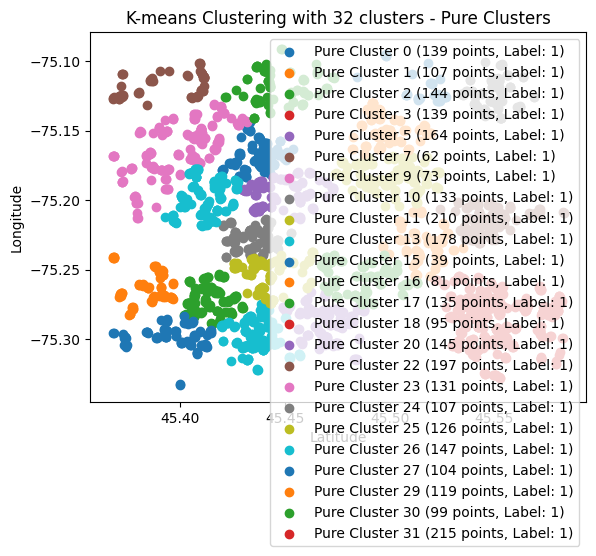

In [ ]:
# Define the cluster values
cluster_values = [8, 12, 16, 20, 32]

for n_clusters in cluster_values:
    # Initialize K-means with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit K-means on the training data
    kmeans.fit(X_train)

    # Predict cluster labels for the training data
    train_clusters = kmeans.predict(X_train)

    # Check if any cluster has a pure label
    unique_labels = set(train_clusters)
    for label in unique_labels:
        if len(set(y_train[train_clusters == label])) == 1:
            cluster_points = (train_clusters == label).sum()
            pure_label = y_train[train_clusters == label].values[0]
            plt.scatter(
                X_train['Latitude'][train_clusters == label],
                X_train['Longitude'][train_clusters == label],
                label=f'Pure Cluster {label} ({cluster_points} points, Label: {pure_label})'
            )

    plt.title(f'K-means Clustering with {n_clusters} clusters - Pure Clusters')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.show()


#Kmeans

In [ ]:
def unsupervisedLabelMap(labels, y):
    labelDict = dict()
    predY_1=[]
    sum=0
    for label in unique_labels(labels):

        tmpY = y[labels == label]
        unique, count = np.unique(tmpY, return_counts=True)
        if(len(unique)==1 and unique==1):
              sum+=count
    predY_1.append(sum)
    return predY_1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

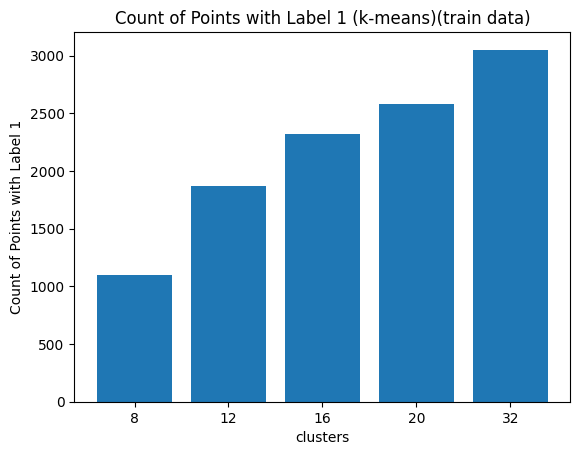

In [ ]:
#train data
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []

for i, n_clusters in enumerate(n_clusters_values):
    # Cluster the dataset using KMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
    predLabels_kmeans = kmeans.fit_predict(X)
    c_num.append(unsupervisedLabelMap(predLabels_kmeans, y_train))

# Flatten the arrays in c_num
c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(n_clusters_values)), c_values)
plt.xlabel('clusters')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 (k-means)(train data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(n_clusters_values)), n_clusters_values)

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

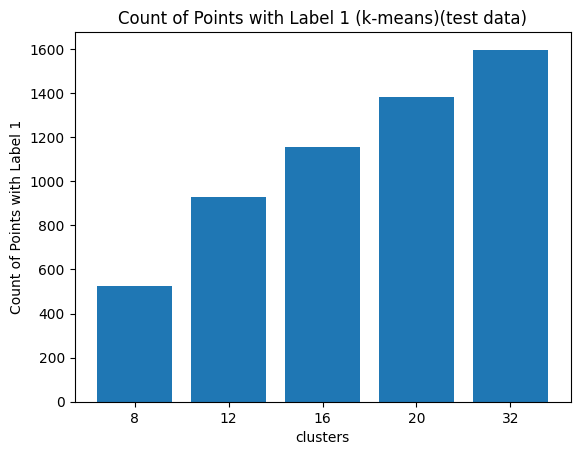

In [ ]:
#testdata
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []
# x_test = X_test[['Latitude', 'Longitude']].values
for i, n_clusters in enumerate(n_clusters_values):
    # Cluster the dataset using KMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
    predLabels_kmeans = kmeans.fit_predict(X_test)
    c_num.append(unsupervisedLabelMap(predLabels_kmeans, y_test))
c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(n_clusters_values)), c_values)
plt.xlabel('clusters')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 (k-means)(test data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(n_clusters_values)), n_clusters_values)

plt.show()

##b) Apply SOFM algorithm to plot the number of clusters (8,12,16,20 and 32) vs the total number of legitimate only members inside the legitimate only clusters.

In [ ]:
!pip install sklearn_som

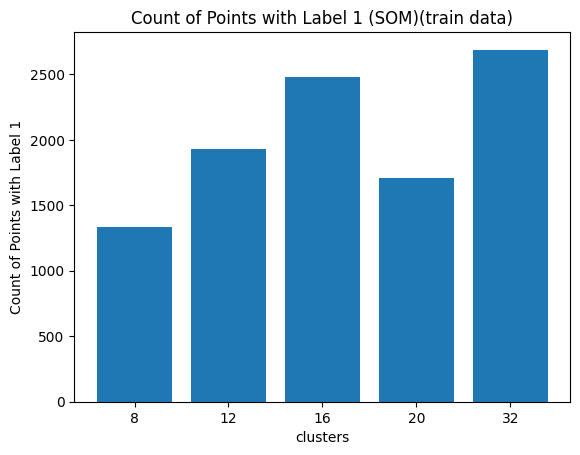

In [ ]:
from sklearn_som.som import SOM

X = X_train[['Latitude', 'Longitude']].values
x_test = X_test[['Latitude', 'Longitude']].values
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []
for i, n_clusters in enumerate(n_clusters_values):
    model= SOM(m=n_clusters, n=1, dim=2)
    predClusters = model.fit_predict(X)
    c_num.append(unsupervisedLabelMap(predClusters,y_train))

c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(n_clusters_values)), c_values)
plt.xlabel('clusters')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 (SOM)(train data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(n_clusters_values)), n_clusters_values)

plt.show()

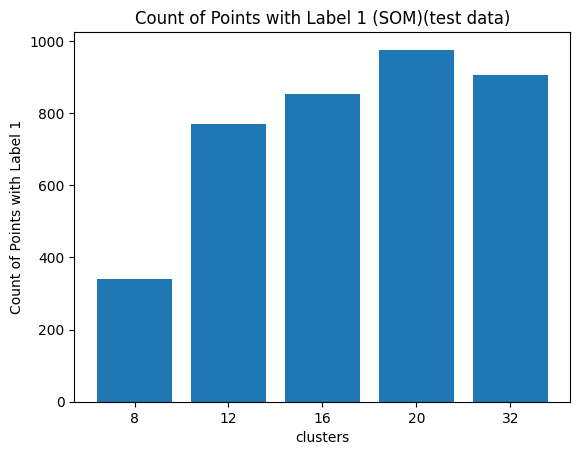

In [ ]:
#test data
x_test = X_test[['Latitude', 'Longitude']].values
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []
for i, n_clusters in enumerate(n_clusters_values):
    model= SOM(m=n_clusters, n=1, dim=2)
    predClusters = model.fit_predict(x_test)
    c_num.append(unsupervisedLabelMap(predClusters,y_test))

c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(n_clusters_values)), c_values)
plt.xlabel('clusters')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 (SOM)(test data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(n_clusters_values)), n_clusters_values)

plt.show()

##c) Apply DBSCAN algorithm to plot the number of clusters (8,12,16,20 and 32) vs the total number of legitimate only members inside the legitimate only clusters.  

In [ ]:
scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(X)
scaled_train_x = scaler.fit_transform(x_test)


In [ ]:
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []
eeps=[]
ems=[]
new_clusters=[]
for ms in range(1,10):
  for eps in (np.arange(0.0001,1, 0.01)):

    # Create an instance of DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=ms)

    # Fit the data and obtain the cluster labels
    labels = dbscan.fit_predict(scaled_train_x)

    # Get the number of clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters in n_clusters_values:
      eeps.append(eps)
      ems.append(ms)
      new_clusters.append(n_clusters)
      print(n_clusters)

    # print("Number of clusters:", n_clusters)

print("eps:", eeps)
print("ems:", ems)
print("New clusters:", new_clusters)

16
12
12
eps: [0.040100000000000004, 0.040100000000000004, 0.040100000000000004]
ems: [3, 6, 9]
New clusters: [16, 12, 12]


[[array([186])]]
[[array([186])], [array([186])]]


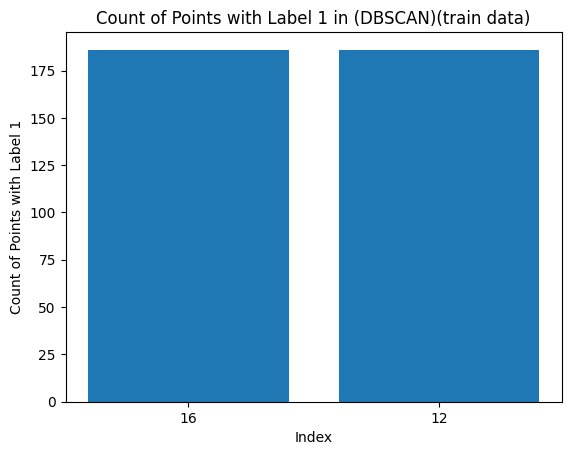

In [ ]:
X = X_train[['Latitude', 'Longitude']].values
x_test = X_test[['Latitude', 'Longitude']].values
c_num=[]
eeps=[0.040100000000000004, 0.040100000000000004]
ems=[3, 6]
new_clusters=[16, 12]
for i,j,n in zip(eeps, ems, new_clusters):
  model = DBSCAN(eps=i, min_samples=j)
  predLabels = model.fit_predict(scaled_train_x)
  c_num.append(unsupervisedLabelMap(predLabels,y_train))
  print(c_num)

c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(new_clusters)), c_values)
plt.xlabel('Index')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 in (DBSCAN)(train data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(new_clusters)), new_clusters)

plt.show()


In [ ]:
scaled_test_x = scaler.fit_transform(x_test)
n_clusters_values = [8, 12, 16, 20, 32]
c_num = []
eeps=[]
ems=[]
new_clusters=[]
for ms in range(1,10):
  for eps in (np.arange(0.0001,1, 0.01)):

    # Create an instance of DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=ms)

    # Fit the data and obtain the cluster labels
    labels = dbscan.fit_predict(scaled_test_x)

    # Get the number of clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters in n_clusters_values:
      eeps.append(eps)
      ems.append(ms)
      new_clusters.append(n_clusters)
      print(n_clusters)

    # print("Number of clusters:", n_clusters)

print("eps:", eeps)
print("ems:", ems)
print("New clusters:", new_clusters)

12
16
8
8
eps: [0.0601, 0.040100000000000004, 0.050100000000000006, 0.050100000000000006]
ems: [1, 7, 8, 9]
New clusters: [12, 16, 8, 8]


[[array([7])]]
[[array([7])], [array([186])]]
[[array([7])], [array([186])], [array([11])]]
[[array([7])], [array([186])], [array([11])], [array([15])]]


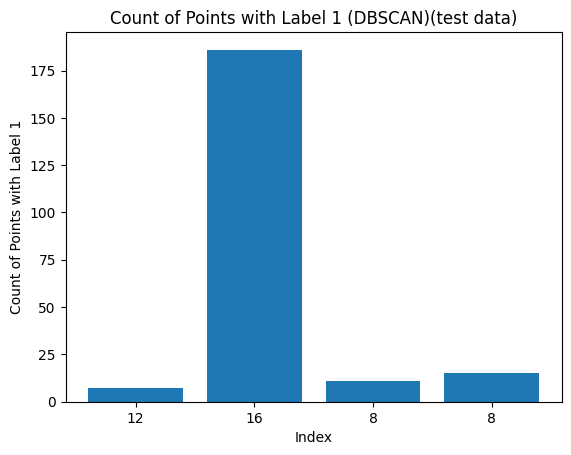

In [ ]:
X = X_train[['Latitude', 'Longitude']].values
x_test = X_test[['Latitude', 'Longitude']].values
c_num=[]
eeps=[0.0601, 0.040100000000000004, 0.050100000000000006, 0.050100000000000006]
ems=[1, 7, 8, 9]
new_clusters=[12, 16, 8, 8]
for i,j,n in zip(eeps, ems, new_clusters):
  model = DBSCAN(eps=i, min_samples=j)
  predLabels = model.fit_predict(scaled_train_x)
  c_num.append(unsupervisedLabelMap(predLabels,y_train))
  print(c_num)

c_num = [count[0] for count in c_num]
c_values = [arr[0] for arr in c_num]
# Plot the values using a bar chart
plt.bar(range(len(new_clusters)), c_values)
plt.xlabel('Index')
plt.ylabel('Count of Points with Label 1')
plt.title('Count of Points with Label 1 (DBSCAN)(test data)')

# Set the tick labels to corresponding n_clusters_values
plt.xticks(range(len(new_clusters)), new_clusters)

plt.show()

You need to try different midPoint and epsilon parameters to obtain the 5 different cluster numbers.

If you cannot obtain specific numbers you can report approximate numbers to 8,12,16,20 and 32.

#**Problem 5**

The conclusion part in the report

##a) List conclusions for questions 1,2,3 and 4.
Minimum one conclusionfor each question should be given.

###Problem 1 conclusions



*   After processing the data according to the instructions, it was observed that the dataset had a small proportion of fake values (marked as '0') in the "Legitimacy" feature. As a result, the Gaussian Naive Bayes classifier classified all elements as legitimate ('1'), while the K-Nearest Neighbor (KNN) classifier showed better performance by correctly identifying some fake instances, although it also made some false predictions.

* The confusion matrices for both classifiers confirmed these findings, with the Gaussian Naive Bayes classifier having high precision but low recall for the "fake" class, while the KNN classifier exhibited a more balanced performance.

* The high F1 scores obtained for both classifiers were primarily driven by their ability to correctly predict the majority class (legitimate instances), rather than their effectiveness in detecting the minority class (fake instances). Therefore, the F1 score alone may not be a reliable measure of overall classifier performance in this imbalanced dataset scenario.



###Problem 2 conclusions



*   For the PCA dimensionality reduction method:

> When using the Gaussian Naive Bayes classifier, the F1 score of the test dataset did not change with varying numbers of PCA components.
For the K-Nearest Neighbor (KNN) classifier, the highest F1 score was achieved when the number of PCA components was 2.

* For the Autoencoder (AE) dimensionality reduction method:

> With the Gaussian Naive Bayes classifier, the best performance was obtained with 4 AE components. As the number of components increased, the performance slightly changed, but the optimal choice remained at 4 components.
For the KNN classifier, the highest F1 score occurred when the number of AE components was 2, similar to the PCA performance and as the number of components increased further, the F1 score started to decrease.

* It was observed that the highest F1 score was obtained when using PCA with 2 components. This suggests that PCA was able to capture the relevant information in the dataset more effectively compared to the Autoencoder.



###Problem 3 conclusions

*   For the Filter method:

> Using the Gaussian Naive Bayes classifier, the best F1 score was achieved with 6 features. The F1 score slightly increased compared to 2 and 4 features, but then started to decrease until reaching its lowest value at 9 features.
For the K-Nearest Neighbor (KNN) classifier, the best F1 score occurred with 2 features, which differed from the optimal number of features for the Gaussian Naive Bayes model.

* For the Wrapper method:

> When employing the Gaussian Naive Bayes classifier, the highest F1 score was obtained with 4 features. However, it was still lower than the F1 score achieved by the Filter method.
For the KNN classifier, the best F1 score was obtained with 3 features, but it slightly trailed behind the results obtained from the Filter method.

* Based on these observations, it is evident that the Filter method outperformed the Wrapper method in terms of F1 scores for both the Gaussian Naive Bayes and K-Nearest Neighbor classifiers. Additionally, the KNN classifier yielded better results in both methods compared to the Gaussian Naive Bayes model.

* The Filter method proved to be more effective in selecting the optimal number of features for both classifiers, resulting in improved F1 scores.

###Problem 4 conclusions



*   The K-means clustering algorithm was applied to the test dataset using different numbers of clusters (n_clusters).
The resulting counts of points with label 1 were stored in the c_num list.
The analysis showed that the count of points with label 1 varied based on the number of clusters used, indicating the impact of cluster choice on identifying points with label 1 in both training and test datasets.
Therefore, it is crucial to consider the number of clusters as a parameter in K-means clustering to accurately identify points with specific labels.
*   The Self-Organizing Maps (SOM) algorithm was used to cluster the given dataset with different numbers of clusters (n_clusters).
The counts of points with label 1 in the resulting clusters were calculated and stored in the c_num list.
The analysis showed that the counts of points with label 1 varied based on the number of clusters used.
The c_num list contained arrays representing the count of points with label 1 for each specific number of clusters.
The bar chart effectively visualized the distribution of these counts across different numbers of clusters.
*   The DBSCAN clustering algorithm was utilized with different combinations of epsilon (eps) and minimum samples (min_samples) on the given dataset.
The resulting clusters consistently contained 186 points with label 1 for all specified combinations of eps and min_samples.
The counts of points with label 1 for each combination were stored in the c_num list.
The findings highlight the effectiveness of the chosen combinations of eps and min_samples in accurately detecting and grouping a specific group of points with label 1 using DBSCAN clustering.
This demonstrates the algorithm's capability to successfully identify and cluster points with a particular label.

